# 필요한 라이브러리 import

[Dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)<br>
[Notebook](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays)

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

## Set-up

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/Ex_9/data/train/*/*'  # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/Ex_9/data/val/*/*'
TEST_PATH = ROOT_PATH + '/Ex_9/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요.
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


# 데이터 준비

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')  # 정상 이미지
print(f'Pneumonia image path\n{filenames[2000]}')  # 폐렴 이미지

Normal image path
/aiffel/aiffel/Ex_9/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/Ex_9/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
# Data imbalance
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"  # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)  # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)  # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path)  # 라벨 검출
    img = tf.io.read_file(file_path)  # 이미지 읽기
    img = decode_img(img)  # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# make (train, val)dataset with AUTOTUNE
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# confirm
for image, label in train_ds.take(1):  # 하나의 데이터만 가져오기
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터 시각화

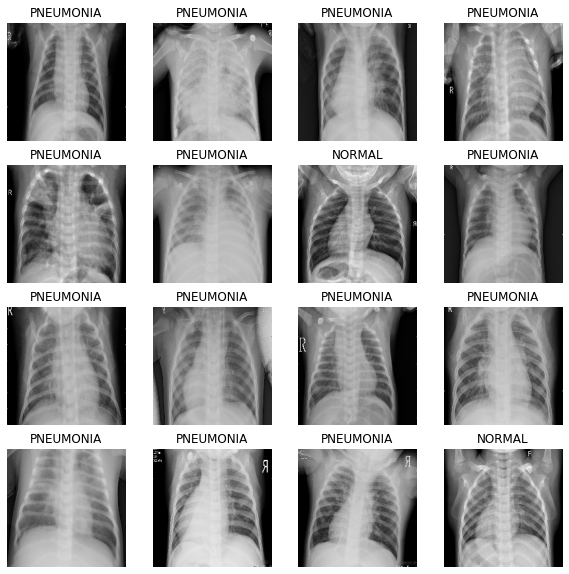

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),  # Regularization (1)
        tf.keras.layers.Dropout(dropout_rate)  # Regularization (2)
    ])
    
    return block

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 데이터 imbalance 처리

In [18]:
# Weight balancing
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [19]:
with tf.device('/GPU:0'):  # GPU 사용
    model = build_model()

    # 성과 측정 지표
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 87s 197ms/step - loss: 0.4456 - accuracy: 0.7625 - precision: 0.9437 - recall: 0.7238 - val_loss: 0.5798 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 193ms/step - loss: 0.2608 - accuracy: 0.8913 - precision: 0.9719 - recall: 0.8794 - val_loss: 0.9394 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 51s 194ms/step - loss: 0.2220 - accuracy: 0.9188 - precision: 0.9753 - recall: 0.9140 - val_loss: 0.1708 - val_accuracy: 0.9269 - val_precision: 0.9107 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 50s 194ms/step - loss: 0.2119 - accuracy: 0.9181 - precision: 0.9703 - recall: 0.9178 - val_loss: 0.1332 - val_accuracy: 0.9452 - val_precision: 0.9958 - val_recall: 0.9293
Epoch 5/25
261/261 [==============================] - 52s 201ms/step - loss: 0.1581 - accura

# 결과 확인

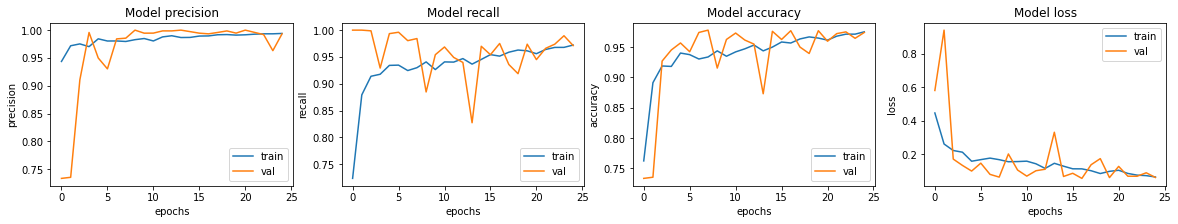

In [21]:
# 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 112ms/step - loss: 1.2024 - accuracy: 0.7724 - precision: 0.7348 - recall: 0.9949
Loss: 1.2024091482162476,
Accuracy: 0.7724359035491943,
Precision: 0.7348484992980957,
Recall: 0.9948717951774597


In [23]:
model.save('my_model3.h5')

In [24]:
print("Model3, accuracy: {:5.2f}%".format(100*accuracy))

Model, accuracy: 77.24%


In [27]:
from tensorflow import keras

model1 = keras.models.load_model('my_model.h5')
model2 = keras.models.load_model('my_model2.h5')

model1.summary()
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

In [30]:
# Basic model(adam)
loss, accuracy, precision, recall = model1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
print("Model1, accuracy: {:5.2f}%".format(100*accuracy))

# (adagrad)
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
print("Model2, accuracy: {:5.2f}%".format(100*accuracy))

39/39 [==============================] - 5s 115ms/step - loss: 0.5318 - accuracy: 0.8782 - precision: 0.8685 - recall: 0.9487
Loss: 0.5317971110343933,
Accuracy: 0.8782051205635071,
Precision: 0.8685445785522461,
Recall: 0.9487179517745972
Model1, accuracy: 87.82%
39/39 [==============================] - 5s 111ms/step - loss: 1.2024 - accuracy: 0.7724 - precision: 0.7348 - recall: 0.9949
Loss: 1.2024091482162476,
Accuracy: 0.7724359035491943,
Precision: 0.7348484992980957,
Recall: 0.9948717951774597
Model2, accuracy: 77.24%


# 회고

- 이번 노드는 데이터의 뷸균형도 있었고 어떻게 처리하는지 캐글의 노트북들을 살펴도 보곤 했다.
- 이미지 증강법도 쓰기도 하였고 노드에서와 같이 좌우반전 또는 상하반전 등을 쓰기도 한다.
- gan도 사용한다면 어떨지 궁금하다.
- 사실 기본 노드로 바로 87%의 정확도가 나오기도 했다.(이후에 하이퍼 파라미터 조정도 해보고 몇가지 해보았는데 새벽에 한번 날라가고...)
- 정확도도 중요하지만 의료 데이터 특성상 진짜 환자를 환자로 판단하는 recall이란 지표도 중요하다.(나름 높게 다 나왔다.)
- 목요일 익스 수업때도 노드 점검에 맞춰 한번더 날라갔다...ㅠ
- 다행히 저장해놓은 모델이 있어 불러오긴 했다만 꼬여서 사실 잘 모르겠다...
- 차후에 다시 해봐야겠고 의료데이터에 대해서 이번에 처음 보게 되었다.(나름 신기도 한데 잘 모르겠다.도메인...)